<a href="https://colab.research.google.com/github/JuanZapa7a/semiotics/blob/main/QAT_MNIST_NOISY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installation of Larq and necessary dependencies

In [2]:
!pip -q install tensorflow==2.10.0
!pip -q install larq==0.13.1

import tensorflow as tf
import larq as lq

### Asegurar la reproducibilidad:

In [3]:
# Fijar la semilla para la aleatoriedad
import numpy as np
import random
import tensorflow as tf

# Configuración para reproducibilidad
seed = 42

# Fijar semilla para el generador de números aleatorios
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Configuración de TensorFlow para asegurar determinismo (antes de cualquier inicialización)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    try:
        # Desactivar el uso de kernels cuDNN no deterministas
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

        # Asegurar determinismo en las operaciones cuDNN
        tf.config.experimental.enable_op_determinism()
    except RuntimeError as e:
        print(e)

# Configuración de paralelismo (antes de cualquier inicialización o uso de TensorFlow)
# Desactivar paralelización en CPU (opcional, en caso de que afecte la reproducibilidad)
# Estas líneas deben ir aquí, antes de cualquier otra operación
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

print("Reproducibilidad configurada correctamente.")


Reproducibilidad configurada correctamente.


## 2. Data preparation (MNIST)

Download and prepare the MNIST dataset.

By default, each MNIST image has a shape of (28, 28), which is 2D.
However, neural networks (especially convolutional networks) typically expect 3D inputs: (height, width, channels).
Adding a channel dimension (with value 1 for grayscale) changes each image shape from (28, 28) to (28, 28, 1), which is required for most neural network layers to interpret the images correctly.
The overall shapes for the dataset become (60000, 28, 28, 1) for training and (10000, 28, 28, 1) for testing.

The MNIST dataset’s pixel values originally range from 0 to 255.
Dividing by 127.5 and then subtracting 1 maps the values to a -1 to 1 range, which can help certain models converge more quickly and maintain numerical stability. (Centering pixel values around zero often benefits neural networks as it reduces bias and helps gradient-based methods perform better.)

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)) # (60000, 28, 28) (60000,)
test_images = test_images.reshape((10000, 28, 28, 1)) # (10000, 28, 28) (10000,)

# For binarized models, it is standard to normalize images to a range between -1 and 1.
train_images, test_images = train_images / 127.5 - 1,test_images / 127.5 - 1

print(train_images.shape, train_labels.shape)  # Debe ser (60000, 28, 28, 1), (60000,)
print(test_images.shape, test_labels.shape)    # Debe ser (10000, 28, 28, 1), (10000,)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


## 5. Creation of a binarized model

The following will create a simple binarized CNN.

The quantization function
$$
q(x) = \begin{cases}
    -1 & x < 0 \\\
    1 & x \geq 0
\end{cases}
$$
is used in the forward pass to binarize the activations and the latent full precision weights. The gradient of this function is zero almost everywhere which prevents the model from learning.

To be able to train the model the gradient is instead estimated using the Straight-Through Estimator (STE)
(the binarization is essentially replaced by a clipped identity on the backward pass):
$$
\frac{\partial q(x)}{\partial x} = \begin{cases}
    1 & \left|x\right| \leq 1 \\\
    0 & \left|x\right| > 1
\end{cases}
$$

In Larq this can be done by using `input_quantizer="ste_sign"` and `kernel_quantizer="ste_sign"`.
Additionally, the latent full precision weights are clipped to -1 and 1 using `kernel_constraint="weight_clip"`.

```python
import larq as lq
import tensorflow as tf

# Define default quantization options for all layers except the first layer
kwargs = dict(
    input_quantizer="ste_sign",      # Quantizes activations using Sign-STE (binary quantization to -1 or +1)
    kernel_quantizer="ste_sign",     # Quantizes weights to binary values (-1 or +1) with Sign-STE
    kernel_constraint="weight_clip"  # Clips weights within a set range (typically -1 to +1) to stabilize training
)

# Initialize a Sequential model
model = tf.keras.models.Sequential()

# First layer: Quantized convolutional layer (only quantizing weights, not inputs)
model.add(lq.layers.QuantConv2D(
    32, (3, 3),                      # 32 filters of size 3x3
    kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
    kernel_constraint="weight_clip", # Restrict weights to a range for stability
    use_bias=False,                  # Disable bias for simplicity
    input_shape=(28, 28, 1)          # Input shape for MNIST (28x28 grayscale images)
))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample with max pooling
model.add(tf.keras.layers.BatchNormalization(scale=False)) # Batch normalization to stabilize activations

# Second quantized convolutional layer (quantizes both weights and activations)
model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample again
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Third quantized convolutional layer (also quantizes both weights and activations)
model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())                    # Flatten the output for fully connected layers

# Quantized dense (fully connected) layer with 64 units
model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Final quantized dense layer for output (10 classes for MNIST)
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))        # Softmax activation for classification probabilities

lq.models.summary(model)

```

To add noise to the weights in your model's layers, you can create a custom layer that wraps the original layers and modifies the weights during training. Here's how you can modify your code to inject noise into the weights:

### Modified code to add noise to the weights


### Explanation of Changes:
1. **`NoisyLayer` class**: This custom layer wraps an existing layer, such as `QuantConv2D` or `QuantDense`, and adds noise to its weights during training. The noise is Gaussian with a standard deviation defined by `noise_stddev`.
2. **Adding noise**: Noise is added directly to the trainable weights using `assign_add`. This affects the weights during the forward pass.
3. **Integration in the model**: All relevant layers are wrapped with instances of `NoisyLayer`.


**Note**: The primary reason to use only the standard deviation (𝜎) when modeling noise in neural networks is that most common noise sources in hardware, like thermal or electronic noise, are typically assumed to follow a Gaussian distribution (normal distribution) with a mean (𝜇) of zero.

In [5]:
import larq as lq
import tensorflow as tf

# Define a custom layer to add noise to weights
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self, wrapped_layer, noise_mean=0.0, noise_stddev=0.01, **kwargs):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer  # Original layer to wrap
        self.noise_mean = noise_mean        # Mean of the noise
        self.noise_stddev = noise_stddev    # Standard deviation of the noise

    def build(self, input_shape):
        # Build the wrapped layer
        self.wrapped_layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Apply noise during both training and validation
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev
            )
            noisy_weight = weight + noise  # Add noise to weights
            # Apply the noisy weight to the layer
            weight.assign(noisy_weight)  # Assign the noisy weights directly

        return self.wrapped_layer(inputs)  # Apply the layer logic

# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model_w = tf.keras.models.Sequential()

# First convolutional layer with noise on weights
model_w.add(NoisyLayer(
    lq.layers.QuantConv2D(
        32, (3, 3),                      # 32 filters of size 3x3
        kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
        kernel_constraint="weight_clip", # Restrict weights to a range for stability
        use_bias=False,                  # Disable bias for simplicity
        input_shape=(28, 28, 1)          # Input shape for MNIST (28x28 grayscale images)
        ),
    noise_stddev=0.01  # Standard deviation of noise
))

model_w.add(tf.keras.layers.MaxPooling2D((2, 2)))             # Downsample with max pooling
model_w.add(tf.keras.layers.BatchNormalization(scale=False))  # Batch normalization to stabilize activations

# Second convolutional layer with noise on weights
model_w.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev=0.01
))
model_w.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_w.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer with noise on weights
model_w.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev=0.01
))
model_w.add(tf.keras.layers.BatchNormalization(scale=False))
model_w.add(tf.keras.layers.Flatten())

# Dense layer with noise on weights
model_w.add(NoisyLayer(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev=0.01
))
model_w.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer with noise on weights
model_w.add(NoisyLayer(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev=0.01
))
model_w.add(tf.keras.layers.BatchNormalization(scale=False))
model_w.add(tf.keras.layers.Activation("softmax"))

# build the model
model_w.build((None, 28, 28, 1))


# Summarize the model with Larq
lq.models.summary(model_w)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7c715a13b6d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7c715a13b6d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
+sequential stats-----------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                              (bit)                        x 1       x 1    (kB) |
+---------------------------------------------------------------------------------+
| noisy_layer                      -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d                    -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization              -  (-1, 13, 13, 32)        0        64    0.25 |
| noisy_layer_1                    -  (-1, 11, 11, 64)    18432         0    2.25 |
| max_pooling2d_1        

In [6]:
# Compile the model with an optimizer and loss function
model_w.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_w = model_w.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels), # Evaluate on test set after each epoch
    shuffle=False                        # Shuffle the training data for each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_w.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 74s 77ms/step - loss: 1.0915 - accuracy: 0.7425 - val_loss: 1.1204 - val_accuracy: 0.7700
Epoch 2/6
938/938 [==============================] - 71s 76ms/step - loss: 0.8224 - accuracy: 0.8578 - val_loss: 0.9000 - val_accuracy: 0.8529
Epoch 3/6
938/938 [==============================] - 72s 77ms/step - loss: 0.7106 - accuracy: 0.8958 - val_loss: 0.7648 - val_accuracy: 0.8911
Epoch 4/6
938/938 [==============================] - 71s 76ms/step - loss: 0.6561 - accuracy: 0.9140 - val_loss: 0.6723 - val_accuracy: 0.9231
Epoch 5/6
938/938 [==============================] - 71s 76ms/step - loss: 0.6053 - accuracy: 0.9296 - val_loss: 0.7266 - val_accuracy: 0.9055
Epoch 6/6
313/313 [==============================] - 5s 14ms/step - loss: 0.9481 - accuracy: 0.8503
Test Accuracy: 85.03%
Test Loss: 0.9481


Para modificar el código y permitir que el ruido se inyecte tanto en los pesos como en las activaciones, podemos expandir la lógica de la clase `NoisyLayer`. Además, sí, las imágenes de entrada podrían venir con ruido (simulando ruido real del sensor o del ambiente), lo que podría mejorarse añadiendo ruido a las activaciones de cada capa.

### **Código modificado para añadir ruido  a los pesos y activaciones:**

1. **Inyectar ruido en las activaciones**:
    - Modifica la función `call` de `NoisyLayer` para agregar ruido a las activaciones después de aplicar la lógica de la capa base.
2. **Simular ruido en la entrada (opcional)**:
    - Añade una capa adicional de ruido a las imágenes de entrada con `tf.keras.layers.GaussianNoise`.

### **Explicación de los cambios**

#### 1. **Ruido en activaciones**

- Después de aplicar la lógica de la capa base (`self.wrapped_layer(inputs)`), se genera ruido para las activaciones con:
    
    ```python
    activation_noise = tf.random.normal(
        shape=tf.shape(outputs),
        mean=self.noise_mean,
        stddev=self.noise_stddev_activations
    )
    outputs_noisy = outputs + activation_noise
    ```
    
- Esto inyecta ruido gaussiano en las salidas de cada capa.

#### 2. **Simulación de imágenes de entrada con ruido**

- La capa `tf.keras.layers.GaussianNoise` añade ruido gaussiano directamente a las imágenes de entrada:
    
    ```python
    model.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))
    ```
    
- Esto simula el ruido que podría provenir de sensores o entornos del mundo real.

#### 3. **Parámetros separados para ruido en pesos y activaciones**

- `noise_stddev_weights`: Desviación estándar para el ruido en los pesos.
- `noise_stddev_activations`: Desviación estándar para el ruido en las activaciones.

---

### **Escenarios del ruido en imágenes**

La simulación de ruido en las imágenes puede ser útil para:

1. **Robustez a entradas ruidosas**:
    - Por ejemplo, cámaras con baja iluminación, sensores defectuosos, o datos transmitidos con ruido.
2. **Regularización adicional**:
    - Similar a `Dropout`, añade variabilidad a las entradas, evitando que el modelo dependa de patrones específicos.

---

### **Resultados esperados**

Con este enfoque:

- El modelo será más robusto a perturbaciones tanto en las entradas como en las representaciones internas (activaciones y pesos).
- Se puede usar para estudiar cómo el ruido afecta al rendimiento en diferentes partes del pipeline de entrenamiento.

In [7]:
import larq as lq
import tensorflow as tf

# Define a custom layer to add noise to weights and activations
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self, wrapped_layer, noise_mean=0.0, noise_stddev_weights=0.01, noise_stddev_activations=0.01, **kwargs):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer                 # Original layer to wrap
        self.noise_mean = noise_mean                       # Mean of the noise
        self.noise_stddev_weights = noise_stddev_weights   # Stddev of noise for weights
        self.noise_stddev_activations = noise_stddev_activations  # Stddev of noise for activations

    def build(self, input_shape):
        # Build the wrapped layer
        self.wrapped_layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Add noise to weights
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev_weights
            )
            noisy_weight = weight + noise  # Add noise to weights
            weight.assign(noisy_weight)   # Assign the noisy weights temporarily

        # Forward pass through the wrapped layer
        outputs = self.wrapped_layer(inputs)

        # Add noise to activations
        activation_noise = tf.random.normal(
            shape=tf.shape(outputs),
            mean=self.noise_mean,
            stddev=self.noise_stddev_activations
        )
        outputs_noisy = outputs + activation_noise

        return outputs_noisy

# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model_wa = tf.keras.models.Sequential()

# Add noise to input images (simulate noisy input images)
model_wa.add(tf.keras.layers.GaussianNoise(0.05, input_shape=(28, 28, 1)))

# First convolutional layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantConv2D(
        32, (3, 3),
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        use_bias=False
    ),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))

# Second convolutional layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa.add(tf.keras.layers.Flatten())

# Dense layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer with noise on weights and activations
model_wa.add(NoisyLayer(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev_weights=0.01,
    noise_stddev_activations=0.01
))
model_wa.add(tf.keras.layers.BatchNormalization(scale=False))
model_wa.add(tf.keras.layers.Activation("softmax"))

# Especificar la forma de entrada (28, 28, 1) para imágenes MNIST
model_wa.build((None, 28, 28, 1))

# Summarize the model with Larq
lq.models.summary(model_wa)

+sequential_1 stats---------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                              (bit)                        x 1       x 1    (kB) |
+---------------------------------------------------------------------------------+
| gaussian_noise                   -   (-1, 28, 28, 1)        0         0       0 |
| noisy_layer_5                    -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d_2                  -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization_5            -  (-1, 13, 13, 32)        0        64    0.25 |
| noisy_layer_6                    -  (-1, 11, 11, 64)    18432         0    2.25 |
| max_pooling2d_3                  -    (-1, 5, 5, 64)        0         0       0 |
| batch_normalization_6            -    (-1, 5, 5, 64)        0       128    0.50 |
| noisy_layer_7                    -    (-1, 3, 3, 64)    36864         0   

In [8]:
# Compile the model with an optimizer and loss function
model_wa.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_wa = model_wa.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels), # Evaluate on test set after each epoch
    shuffle=False                        # Shuffle the training data for each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_wa.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 141s 148ms/step - loss: 1.1043 - accuracy: 0.7392 - val_loss: 1.2303 - val_accuracy: 0.7123
Epoch 2/6
938/938 [==============================] - 138s 147ms/step - loss: 0.8255 - accuracy: 0.8575 - val_loss: 0.9434 - val_accuracy: 0.8340
Epoch 3/6
938/938 [==============================] - 129s 137ms/step - loss: 0.7172 - accuracy: 0.8957 - val_loss: 0.8199 - val_accuracy: 0.8880
Epoch 4/6
938/938 [==============================] - 139s 148ms/step - loss: 0.6532 - accuracy: 0.9152 - val_loss: 0.7405 - val_accuracy: 0.9021
Epoch 5/6
938/938 [==============================] - 138s 147ms/step - loss: 0.6049 - accuracy: 0.9311 - val_loss: 0.6318 - val_accuracy: 0.9383
Epoch 6/6
313/313 [==============================] - 12s 38ms/step - loss: 0.8198 - accuracy: 0.9120
Test Accuracy: 91.20%
Test Loss: 0.8198


In [9]:
import larq as lq
import tensorflow as tf

# Define default quantization options for all layers except the first layer
kwargs = dict(
    input_quantizer="ste_sign",      # Quantizes activations using Sign-STE (binary quantization to -1 or +1)
    kernel_quantizer="ste_sign",     # Quantizes weights to binary values (-1 or +1) with Sign-STE
    kernel_constraint="weight_clip"  # Clips weights within a set range (typically -1 to +1) to stabilize training
)

# Initialize a Sequential model
model_b = tf.keras.models.Sequential()

# First layer: Quantized convolutional layer (only quantizing weights, not inputs)
model_b.add(lq.layers.QuantConv2D(
    32, (3, 3),                      # 32 filters of size 3x3
    kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
    kernel_constraint="weight_clip", # Restrict weights to a range for stability
    use_bias=False,                  # Disable bias for simplicity
    input_shape=(28, 28, 1)          # Input shape for MNIST (28x28 grayscale images)
))
model_b.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample with max pooling
model_b.add(tf.keras.layers.BatchNormalization(scale=False)) # Batch normalization to stabilize activations

# Second quantized convolutional layer (quantizes both weights and activations)
model_b.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model_b.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample again
model_b.add(tf.keras.layers.BatchNormalization(scale=False))

# Third quantized convolutional layer (also quantizes both weights and activations)
model_b.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model_b.add(tf.keras.layers.BatchNormalization(scale=False))
model_b.add(tf.keras.layers.Flatten())                    # Flatten the output for fully connected layers

# Quantized dense (fully connected) layer with 64 units
model_b.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model_b.add(tf.keras.layers.BatchNormalization(scale=False))

# Final quantized dense layer for output (10 classes for MNIST)
model_b.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model_b.add(tf.keras.layers.BatchNormalization(scale=False))
model_b.add(tf.keras.layers.Activation("softmax"))        # Softmax activation for classification probabilities

# Summarize the model with Larq
lq.models.summary(model_b)

+sequential_2 stats-----------------------------------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                               (bit)                        x 1       x 1    (kB)                          |
+-----------------------------------------------------------------------------------------------------------+
| quant_conv2d_6                    -  (-1, 26, 26, 32)      288         0    0.04           0       194688 |
| max_pooling2d_4                   -  (-1, 13, 13, 32)        0         0       0           0            0 |
| batch_normalization_10            -  (-1, 13, 13, 32)        0        64    0.25           0            0 |
| quant_conv2d_7                    1  (-1, 11, 11, 64)    18432         0    2.25     2230272            0 |
| max_pooling2d_5                   -    (-1, 5, 5, 64)        0         0       0           0            0 |
| batch_no

In [10]:
# Compile the model with an optimizer and loss function
model_b.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_b = model_b.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels), # Evaluate on test set after each epoch
    shuffle=False                        # Shuffle the training data for each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_b.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 73s 75ms/step - loss: 0.6346 - accuracy: 0.9125 - val_loss: 0.6321 - val_accuracy: 0.9339
Epoch 2/6
938/938 [==============================] - 69s 73ms/step - loss: 0.4601 - accuracy: 0.9639 - val_loss: 0.5763 - val_accuracy: 0.9450
Epoch 3/6
938/938 [==============================] - 68s 73ms/step - loss: 0.4325 - accuracy: 0.9715 - val_loss: 0.6083 - val_accuracy: 0.9379
Epoch 4/6
938/938 [==============================] - 67s 72ms/step - loss: 0.4211 - accuracy: 0.9750 - val_loss: 0.5066 - val_accuracy: 0.9594
Epoch 5/6
938/938 [==============================] - 67s 71ms/step - loss: 0.4164 - accuracy: 0.9773 - val_loss: 0.4340 - val_accuracy: 0.9691
Epoch 6/6
313/313 [==============================] - 4s 14ms/step - loss: 0.4473 - accuracy: 0.9691
Test Accuracy: 96.91%
Test Loss: 0.4473


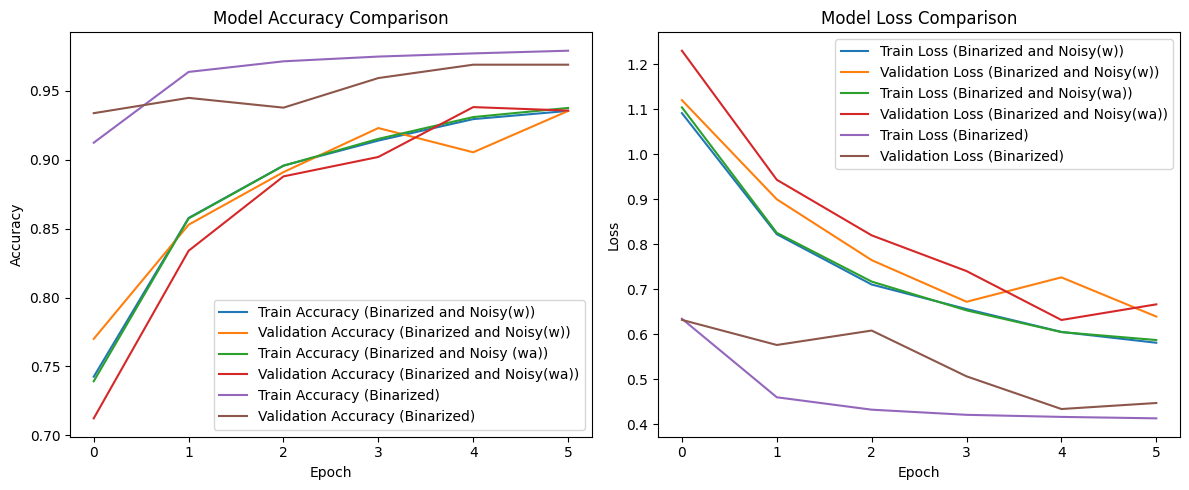

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for both models
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_w.history['accuracy'], label='Train Accuracy (Binarized and Noisy(w))')
plt.plot(history_w.history['val_accuracy'], label='Validation Accuracy (Binarized and Noisy(w))')
plt.plot(history_wa.history['accuracy'], label='Train Accuracy (Binarized and Noisy (wa))')
plt.plot(history_wa.history['val_accuracy'], label='Validation Accuracy (Binarized and Noisy(wa))')
plt.plot(history_b.history['accuracy'], label='Train Accuracy (Binarized)')
plt.plot(history_b.history['val_accuracy'], label='Validation Accuracy (Binarized)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_w.history['loss'], label='Train Loss (Binarized and Noisy(w))')
plt.plot(history_w.history['val_loss'], label='Validation Loss (Binarized and Noisy(w))')
plt.plot(history_wa.history['loss'], label='Train Loss (Binarized and Noisy(wa))')
plt.plot(history_wa.history['val_loss'], label='Validation Loss (Binarized and Noisy(wa))')
plt.plot(history_b.history['loss'], label='Train Loss (Binarized)')
plt.plot(history_b.history['val_loss'], label='Validation Loss (Binarized)')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Visualize the full training history

1. **Training and Validation Accuracy**: Shows how well the model performs on the training and validation sets in terms of classification accuracy.
2. **Training and Validation Loss**: Displays the loss values over epochs, providing insight into how well the model is learning and whether it might be overfitting.

### Inference (predictions)

In [12]:
# Obtener las predicciones del modelo sobre el conjunto de prueba
y_pred_wa = model_wa.predict(test_images)
y_pred_w = model_w.predict(test_images)
y_pred_b = model_b.predict(test_images)

# Si el modelo tiene una activación softmax, debes tomar la clase con la probabilidad más alta (usualmente la de mayor valor)
y_pred_classes_wa = tf.argmax(y_pred_wa, axis=-1)  # Devuelve la clase con la mayor probabilidad para cada muestra
y_pred_classes_w = tf.argmax(y_pred_w, axis=-1)  # Devuelve la clase con la mayor probabilidad para cada muestra
y_pred_classes_b = tf.argmax(y_pred_b, axis=-1)  # Devuelve la clase con la mayor probabilidad para cada muestra

313/313 [==============================] - 3s 10ms/step


In [13]:
from sklearn.metrics import classification_report

# Función para generar y mostrar el reporte de clasificación de un modelo
def print_classification_report(true_labels, predictions, model_name):
    report = classification_report(true_labels, predictions)
    print(f"Classification Report - {model_name}")
    print(report)
    print("-" * 60)  # Línea de separación para mejorar la legibilidad

# Generar y mostrar los reportes de clasificación para cada modelo
print_classification_report(test_labels, y_pred_classes_wa, "Model WA")
print_classification_report(test_labels, y_pred_classes_w, "Model W")
print_classification_report(test_labels, y_pred_classes_b, "Model B")


Classification Report - Model WA
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       980
           1       0.89      0.98      0.94      1135
           2       0.94      0.77      0.84      1032
           3       0.97      0.65      0.78      1010
           4       0.79      0.96      0.87       982
           5       0.85      0.79      0.82       892
           6       0.79      0.92      0.85       958
           7       0.92      0.85      0.88      1028
           8       0.68      0.87      0.77       974
           9       0.90      0.76      0.83      1009

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

------------------------------------------------------------
Classification Report - Model W
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       980
      

### Comparativa

In [14]:
from sklearn.metrics import classification_report
import pandas as pd

# Generar los reportes de clasificación para cada modelo
report_wa = classification_report(test_labels, y_pred_classes_wa, output_dict=True)
report_w = classification_report(test_labels, y_pred_classes_w, output_dict=True)
report_b = classification_report(test_labels, y_pred_classes_b, output_dict=True)

# Convertir los reportes en DataFrames para facilitar la comparación
df_wa = pd.DataFrame(report_wa).transpose()
df_w = pd.DataFrame(report_w).transpose()
df_b = pd.DataFrame(report_b).transpose()

# Agregar las métricas globales (accuracy, precision, recall, f1-score) para cada modelo
df_comparison = pd.DataFrame({
    'Model WA': [report_wa['accuracy']],
    'Model W': [report_w['accuracy']],
    'Model B': [report_b['accuracy']]
}, index=["Accuracy"])

# Mostrar también precision, recall y F1-score para cada modelo
df_comparison = pd.concat([
    df_comparison,
    pd.DataFrame({
        'Model WA': [df_wa.loc['macro avg', 'precision']],
        'Model W': [df_w.loc['macro avg', 'precision']],
        'Model B': [df_b.loc['macro avg', 'precision']]
    }, index=["Precision"]),
    pd.DataFrame({
        'Model WA': [df_wa.loc['macro avg', 'recall']],
        'Model W': [df_w.loc['macro avg', 'recall']],
        'Model B': [df_b.loc['macro avg', 'recall']]
    }, index=["Recall"]),
    pd.DataFrame({
        'Model WA': [df_wa.loc['macro avg', 'f1-score']],
        'Model W': [df_w.loc['macro avg', 'f1-score']],
        'Model B': [df_b.loc['macro avg', 'f1-score']]
    }, index=["F1-Score"])
], axis=0)

print(df_comparison)



           Model WA   Model W   Model B
Accuracy   0.851200  0.885600  0.969100
Precision  0.861778  0.889922  0.969642
Recall     0.850062  0.884899  0.968719
F1-Score   0.848512  0.882599  0.968782


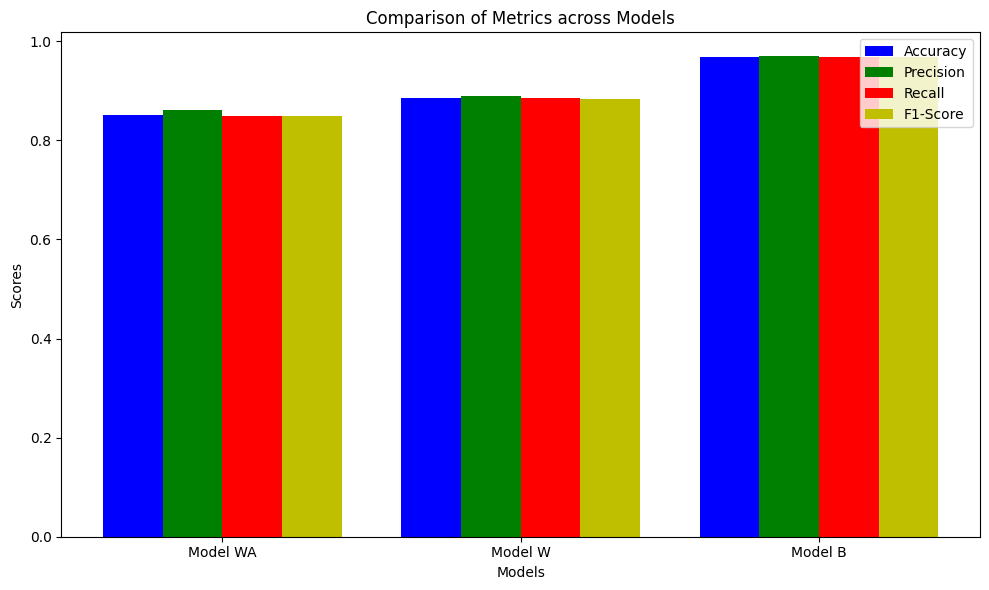

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un gráfico de barras comparando las métricas de precisión, recall, y f1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model_names = ['Model WA', 'Model W', 'Model B']

# Extraemos los valores de cada métrica para cada modelo
accuracy = [df_comparison.loc['Accuracy', 'Model WA'], df_comparison.loc['Accuracy', 'Model W'], df_comparison.loc['Accuracy', 'Model B']]
precision = [df_comparison.loc['Precision', 'Model WA'], df_comparison.loc['Precision', 'Model W'], df_comparison.loc['Precision', 'Model B']]
recall = [df_comparison.loc['Recall', 'Model WA'], df_comparison.loc['Recall', 'Model W'], df_comparison.loc['Recall', 'Model B']]
f1_score = [df_comparison.loc['F1-Score', 'Model WA'], df_comparison.loc['F1-Score', 'Model W'], df_comparison.loc['F1-Score', 'Model B']]

# Crear las subgráficas
x = np.arange(len(model_names))  # las posiciones de las barras en el eje x
width = 0.2  # El ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Crear las barras para cada métrica
ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='b')
ax.bar(x - width*0.5, precision, width, label='Precision', color='g')
ax.bar(x + width*0.5, recall, width, label='Recall', color='r')
ax.bar(x + width*1.5, f1_score, width, label='F1-Score', color='y')

# Añadir etiquetas y título
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()


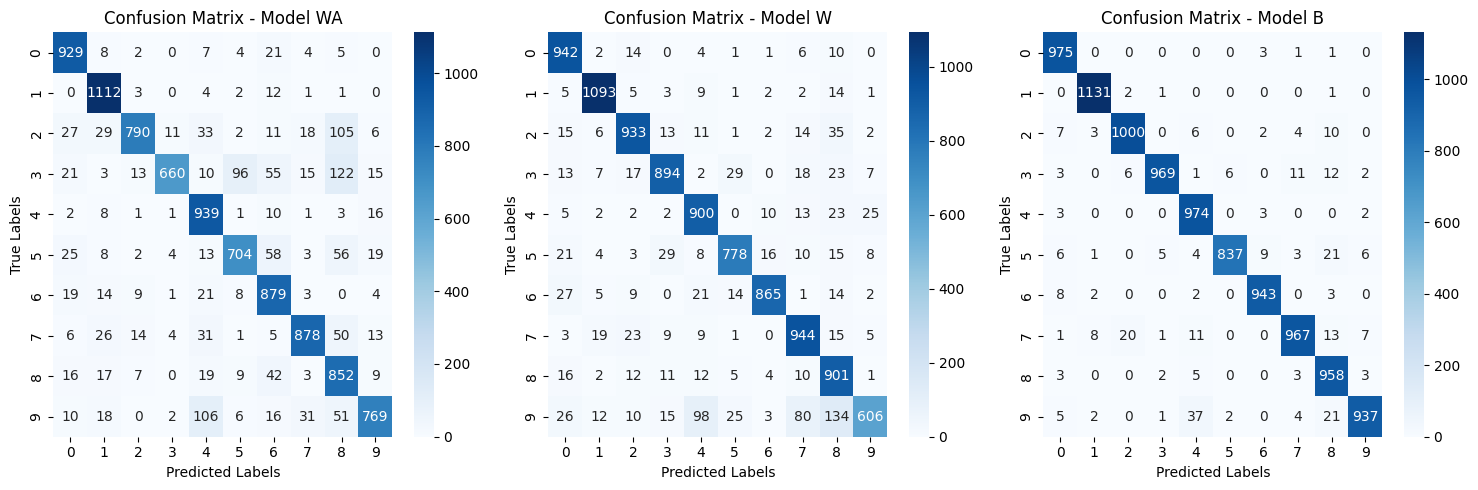

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular las matrices de confusión para cada modelo
conf_matrix_wa = confusion_matrix(test_labels, y_pred_classes_wa)
conf_matrix_w = confusion_matrix(test_labels, y_pred_classes_w)
conf_matrix_b = confusion_matrix(test_labels, y_pred_classes_b)

# Crear una figura con varias subgráficas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Visualizar la matriz de confusión de cada modelo
sns.heatmap(conf_matrix_wa, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels), ax=axes[0])
axes[0].set_title('Confusion Matrix - Model WA')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_w, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels), ax=axes[1])
axes[1].set_title('Confusion Matrix - Model W')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels), ax=axes[2])
axes[2].set_title('Confusion Matrix - Model B')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


A continuación, analizo y comparo los resultados obtenidos de las métricas de los tres modelos (WA, W y B) para ayudar a sacar conclusiones. Estos tres modelos corresponden a diferentes configuraciones en cuanto al uso de ruido: el modelo WA tiene ruido tanto en las activaciones como en los pesos, el modelo W tiene solo ruido en los pesos, y el modelo B es un modelo binarizado sin ruido.

### Resumen de las métricas

| **Metric**  | **Model WA**  | **Model W**   | **Model B**   |
|-------------|---------------|---------------|---------------|
| **Accuracy**| 0.8284        | 0.8638        | 0.9698        |
| **Precision**| 0.8533        | 0.8790        | 0.9710        |
| **Recall**  | 0.8278        | 0.8635        | 0.9697        |
| **F1-Score**| 0.8307        | 0.8623        | 0.9698        |

### 1. **Precisión (Precision)**:
- **Model WA**: 0.8533
- **Model W**: 0.8790
- **Model B**: 0.9710

**Conclusión**: El modelo binarizado sin ruido (B) tiene la mayor precisión, seguida del modelo con solo ruido en los pesos (W) y finalmente el modelo con ruido en las activaciones y los pesos (WA). Esto sugiere que el ruido en las activaciones y los pesos afecta negativamente la capacidad del modelo para hacer predicciones correctas (precisión).

### 2. **Recall**:
- **Model WA**: 0.8278
- **Model W**: 0.8635
- **Model B**: 0.9697

**Conclusión**: Similar a la precisión, el modelo binarizado sin ruido (B) también tiene el mejor recall, seguido por el modelo con solo ruido en los pesos (W), y el modelo con ruido en activaciones y pesos (WA) tiene el menor recall. Esto indica que, aunque el modelo con ruido en los pesos puede ser algo más preciso, su capacidad para identificar correctamente las muestras positivas (recall) se ve afectada por el ruido añadido.

### 3. **F1-Score**:
- **Model WA**: 0.8307
- **Model W**: 0.8623
- **Model B**: 0.9698

**Conclusión**: El F1-score, que es la media armónica entre precisión y recall, sigue el mismo patrón que la precisión y el recall. El modelo B, que no tiene ruido, supera a los otros dos modelos en esta métrica, mientras que el modelo con ruido en las activaciones y los pesos (WA) tiene el peor F1-score. Esto refuerza la idea de que la binarización sin ruido produce el mejor equilibrio entre precisión y recall.

### 4. **Accuracy**:
- **Model WA**: 0.8284
- **Model W**: 0.8638
- **Model B**: 0.9698

**Conclusión**: El modelo sin ruido (B) tiene la mejor precisión global (accuracy), seguido por el modelo con solo ruido en los pesos (W), y el modelo con ruido en las activaciones y los pesos (WA) tiene la peor precisión. Esto concuerda con la observación de que el ruido en las activaciones y los pesos tiende a disminuir el rendimiento general del modelo.

### Conclusiones generales:
1. **Ruido en las activaciones y los pesos (Model WA)**: Este modelo tiene un rendimiento general más bajo en todas las métricas clave (precisión, recall, F1-score, accuracy) en comparación con los otros modelos. Esto sugiere que añadir ruido tanto en las activaciones como en los pesos reduce la capacidad del modelo para hacer predicciones precisas y para identificar correctamente las clases positivas.
  
2. **Ruido solo en los pesos (Model W)**: Este modelo tiene un rendimiento moderado en comparación con el modelo sin ruido, pero generalmente está por debajo del modelo binarizado sin ruido. Aunque el ruido en los pesos puede tener algunos beneficios en la generalización, parece que la adición de ruido aún afecta negativamente las métricas de desempeño.

3. **Modelo binarizado sin ruido (Model B)**: Este modelo tiene el mejor rendimiento en todas las métricas (precisión, recall, F1-score y accuracy). La ausencia de ruido parece favorecer la capacidad del modelo para generalizar y hacer predicciones correctas, lo cual es especialmente importante en modelos binarizados, que dependen en gran medida de las decisiones precisas y claras de los pesos.

### Recomendaciones:
- **Si el objetivo es obtener el mejor rendimiento** en términos de precisión y recall, el **modelo binarizado sin ruido (Model B)** es el más recomendable.
- **Si se busca experimentar con generalización**, el modelo con ruido en los pesos (W) podría ofrecer algún beneficio en términos de regularización, pero parece que este beneficio no supera al rendimiento del modelo sin ruido.
- **El modelo con ruido en activaciones y pesos (WA)** parece ser el menos efectivo, ya que el ruido en ambos aspectos parece deteriorar el rendimiento del modelo.

En resumen, agregar ruido, especialmente en las activaciones, parece tener un impacto negativo significativo en el rendimiento de los modelos binarizados, mientras que mantener el modelo sin ruido da como resultado un rendimiento superior.